In [1]:
# 패키지 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()

In [2]:
# 데이터 로드
with open('oecd_cli.pkl', 'rb') as f:
    oecd_cli_df = pickle.load(f)

with open('usdkrw_price.pkl', 'rb') as f:
    usdkrw_df = pickle.load(f)

In [3]:
oecd_cli_df.index = pd.to_datetime(oecd_cli_df.index)
usdkrw_df.index = pd.to_datetime(usdkrw_df.index)

In [4]:
# 선견편향 제거
oecd_cli_df = oecd_cli_df.shift(1)

# 시점별 국가 수 계산
noc = len(oecd_cli_df.columns) - oecd_cli_df.diff().isna().sum(axis=1)

# 확산 지수
diffusion_index = (oecd_cli_df.diff() > 0).sum(axis=1) / noc

<Axes: >

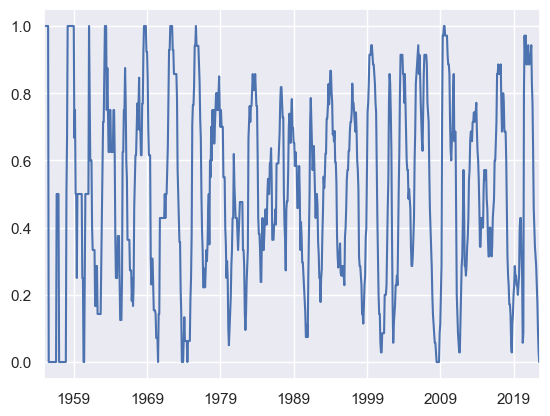

In [5]:
# 확산 지수 그래프
diffusion_index.plot()

In [6]:
# 트레이딩 시그널
fx_signal = -2 * diffusion_index + 1
fx_signal.index = pd.to_datetime(fx_signal.index)

<Axes: >

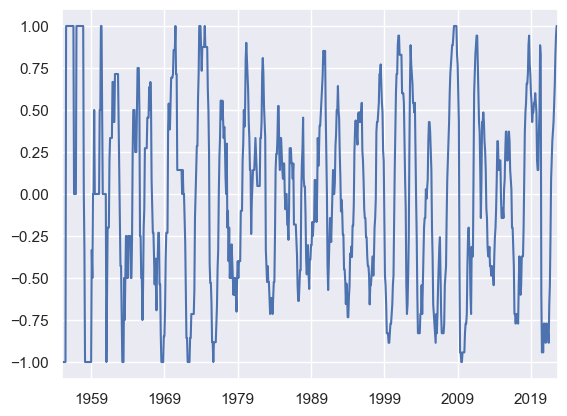

In [7]:
fx_signal.plot()

In [8]:
# 백테스팅
df = pd.concat([fx_signal, usdkrw_df, diffusion_index], axis=1, join='inner')
df.columns = ['fx_signal', 'usdkrw', 'index']
df['fx_rets'] = df['usdkrw'].pct_change().fillna(0)
df['fx_port_rets'] = df['fx_rets'] * df['fx_signal'].shift() - abs(df['fx_signal'].diff()) * 0.0002

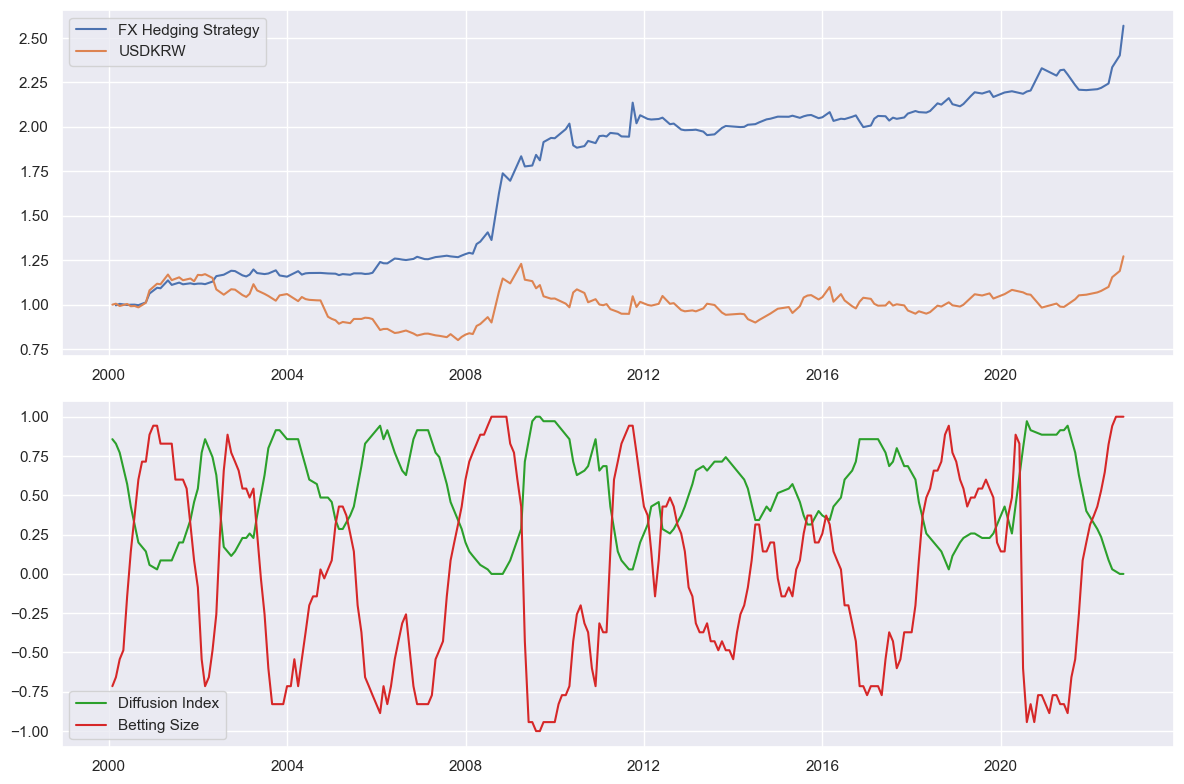

In [9]:
# 시각화
plt.figure(figsize=(12, 8))

# 환율 및 트레이딩 전략
ax1 = plt.subplot(211)
ax1.plot((1 + df['fx_port_rets'].loc['2000':]).cumprod(), label='FX Hedging Strategy')
ax1.plot((1 + df['fx_rets'].loc['2000':]).cumprod(), label='USDKRW')
plt.legend()

# 확산 지수
ax2 = plt.subplot(212)
ax2.plot(df['index'].loc['2000':], label='Diffusion Index', color='tab:green')
ax2.plot(fx_signal.loc['2000':], label='Betting Size', color='tab:red')
plt.legend()
plt.tight_layout()
plt.show()